# Basic use of the package

The following notebook shows you the basics of querying and using the models, following the examples in the library readme.

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from hr_selection_function import HR24SelectionFunction, NStarsPredictor
from astropy.coordinates import SkyCoord
from astropy import units as u

## The selection function

Data download will happen automatically the first time you use the package.

In [4]:
model = HR24SelectionFunction()

The selection function is super easy to use. It takes three arguments: Gaia data density ($\rho_\mathrm{data}$ in the paper), number of stars, and median parallax error.

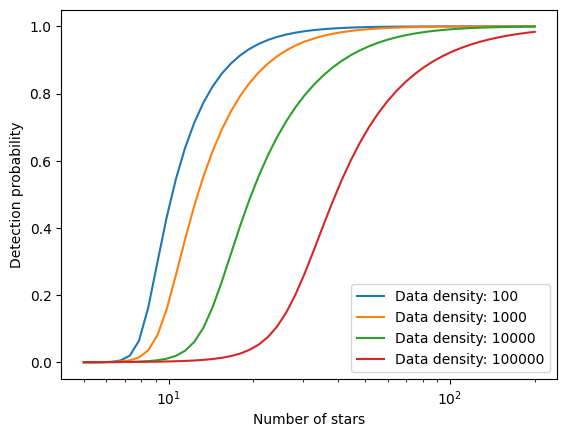

In [5]:
# Pick some basic things
n_stars = np.geomspace(5, 200)
median_parallax_error = np.full(50, 0.1)
threshold = np.full(50, 3)

fig, ax = plt.subplots()
for density in [100, 1000, 10000, 100000]:
    gaia_density = np.full(50, density)
    result = model(gaia_density, n_stars, median_parallax_error, threshold)
    ax.plot(n_stars, result, label=f"Data density: {density:.0f}")

ax.set(xscale="log", xlabel="Number of stars", ylabel="Detection probability")
ax.legend()

It also works if you specify coordinates instead, in cases where you don't know the data density.

[None, Text(0.5, 0, 'Number of stars'), Text(0, 0.5, 'Detection probability')]

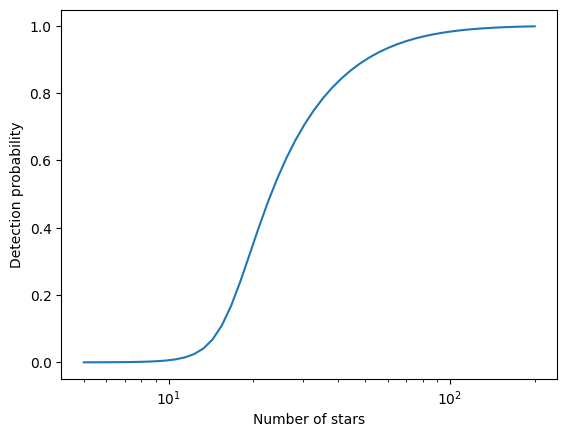

In [6]:
n_stars = np.geomspace(5, 200)
median_parallax_error = np.full(50, 0.1)
threshold = np.full(50, 3)

coordinates = SkyCoord(
    l=np.full(50, 0)*u.deg,
    b=np.full(50, 0)*u.deg,
    pm_l_cosb=np.full(50, 0)*u.mas/u.yr,
    pm_b=np.full(50, 0)*u.mas/u.yr,
    distance=np.full(50, 2000)*u.pc,
    frame="galactic"
)


fig, ax = plt.subplots()
result = model(coordinates, n_stars, median_parallax_error, threshold)
ax.plot(n_stars, result, label=f"Data density: {density:.0f}")

ax.set(xscale="log", xlabel="Number of stars", ylabel="Detection probability")

We can also query different samples of the walkers, and query the model probabilistically! This is useful if you want to incorporate **systematic errors** in the model fit into your eventual work - every time you query the function, you could take a randomly sampled model.

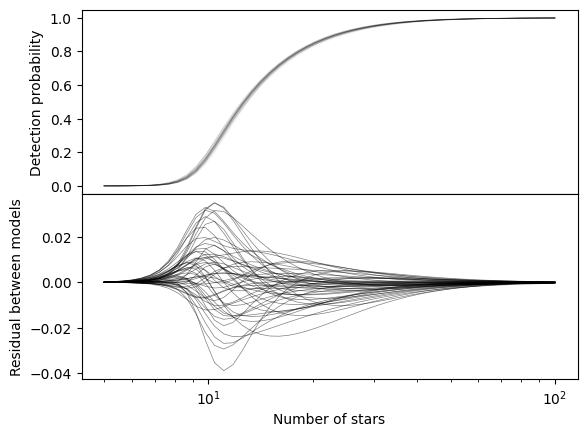

In [7]:
# Pick some basic things
n_stars = np.geomspace(5, 100)
median_parallax_error = np.full(50, 0.1)
threshold = np.full(50, 3)
gaia_density = np.full(50, 1000)

fig, ax = plt.subplots(nrows=2, sharex=True)
result_median = model(gaia_density, n_stars, median_parallax_error, threshold)
for i in range(50):
    result = model(
        gaia_density, n_stars, median_parallax_error, threshold, mode="random_sample"
    )
    ax[0].plot(n_stars, result, "k-", alpha=0.05, lw=0.5)
    ax[1].plot(n_stars, result - result_median, "k-", alpha=0.5, lw=0.5)

ax[0].set(ylabel="Detection probability")
ax[1].set(xscale="log", xlabel="Number of stars", ylabel="Residual between models")

fig.subplots_adjust(hspace=0.)

## The number of stars predictor

If you don't know n_stars or median_parallax_error for your cluster, you can predict it with the `NStarsPredictor` in this library.

In [10]:
# Initialize with lower models number to make it faster for demo. In principle, you
# can use upto 250 models for higher accuracy (and slower speeds.)
nstars_model = NStarsPredictor(models=10)

Querying model 10 of 10


[Text(0.5, 0, 'Mass [MSun]'), Text(0, 0.5, 'Number of stars')]

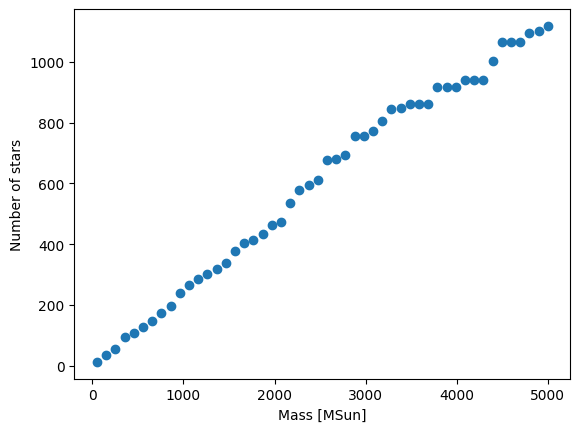

In [11]:
# Pick values to query
mass = np.linspace(50, 5000)
extinction = np.full(50, 1)
log_age = np.full(50, 7.5)
metallicity = np.full(50, 0.0)
differential_extinction = np.full(50, 0.2)

coordinates = SkyCoord(
    l=np.full(50, 0)*u.deg,
    b=np.full(50, 0)*u.deg,
    pm_l_cosb=np.full(50, 0)*u.mas/u.yr,
    pm_b=np.full(50, 0)*u.mas/u.yr,
    distance=np.full(50, 2000)*u.pc,
    frame="galactic"
)

n_stars_predicted, median_parallax_error_predicted = nstars_model(
    coordinates, 
    mass=mass, 
    extinction=extinction, 
    log_age=log_age, 
    metallicity=metallicity, 
    differential_extinction=differential_extinction
)

fig, ax = plt.subplots()

ax.scatter(mass, n_stars_predicted)
ax.set(xlabel="Mass [MSun]", ylabel="Number of stars")

The bouncing around is because it's an _ensemble_ model, and it (sort of) randomly samples the number of stars that a given mass might have.

We can use up to 250 models (the full ensemble) to get the most accurate prediction. **This will take longer to load and run, however.**

We can also ask for full predictions from each model and use them to estimate uncertainties!

In [13]:
nstars_model = NStarsPredictor(models=250)

Querying model 250 of 250


[Text(0.5, 0, 'Mass [MSun]'), Text(0, 0.5, 'Number of stars')]

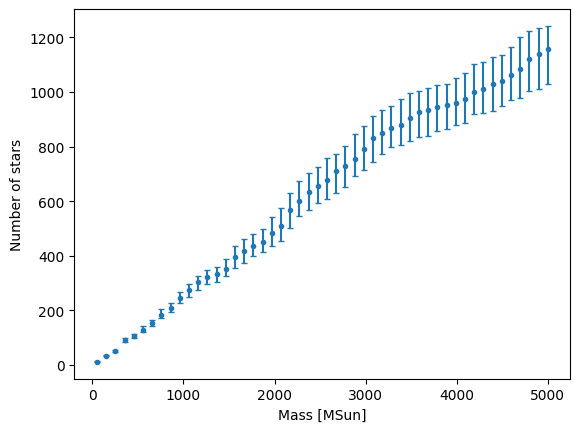

In [14]:
# Pick values to query
mass = np.linspace(50, 5000)
extinction = np.full(50, 1)
log_age = np.full(50, 7.5)
metallicity = np.full(50, 0.0)
differential_extinction = np.full(50, 0.2)

coordinates = SkyCoord(
    l=np.full(50, 0) * u.deg,
    b=np.full(50, 0) * u.deg,
    pm_l_cosb=np.full(50, 0) * u.mas / u.yr,
    pm_b=np.full(50, 0) * u.mas / u.yr,
    distance=np.full(50, 2000) * u.pc,
    frame="galactic",
)

n_stars_predicted, median_parallax_error_predicted = nstars_model(
    coordinates,
    mass=mass,
    extinction=extinction,
    log_age=log_age,
    metallicity=metallicity,
    differential_extinction=differential_extinction,
    mode="full",
)

fig, ax = plt.subplots()

median = np.median(n_stars_predicted, axis=1)
errors = (
        median - np.percentile(n_stars_predicted, 16, axis=1),
        np.percentile(n_stars_predicted, 84, axis=1) - median,
    )
ax.errorbar(
    mass,
    median,
    yerr=errors,
    fmt=".",
    capsize=2
)
ax.set(xlabel="Mass [MSun]", ylabel="Number of stars")

There is still some scatter here (which is to be expected based on sampling & the fact that XGBoost isn't perfect), but this is still an accurate way to go from cluster parameters to number of stars.